# Classification with Python

In this notebook I try to practice all the classification algorithms that I learned in this course.

I load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [127]:
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### About dataset


This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

In [128]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2022-04-20 21:57:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.09s   

2022-04-20 21:57:39 (245 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File

In [129]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [130]:
df.shape

(346, 10)

### Convert to date time object 

In [131]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


## Data visualization and pre-processing


Let’s see how many of each class is in our data set

In [132]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

Lets plot some columns to underestand data better:

In [133]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



In [134]:
from sklearn import preprocessing
import seaborn as sns

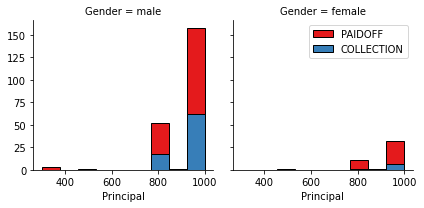

In [135]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

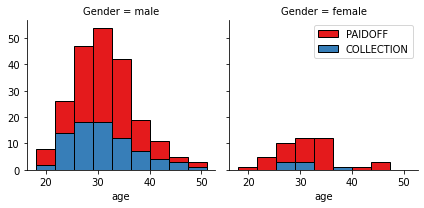

In [136]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

## Pre-processing: Feature selection/extraction


**Lets look at the day of the week people get the loan**

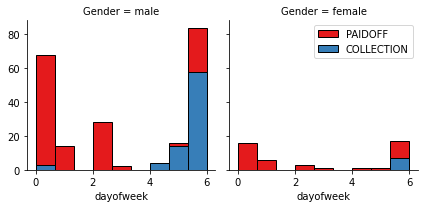

In [137]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Below section shows that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4

In [138]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [139]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan

Lets convert male to 0 and female to 1:

In [140]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

How about education?

In [141]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

### Feature befor One Hot Encoding

In [142]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [143]:
df.describe()

,Unnamed: 0,Unnamed: 0.1,Principal,terms,age,Gender,dayofweek,weekend
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,202.167630,202.167630,943.641618,22.653179,30.939306,0.150289,3.682081,0.592486
std,115.459715,115.459715,109.425530,7.991006,6.039418,0.357872,2.614912,0.492084
min,0.000000,0.000000,300.000000,7.000000,18.000000,0.000000,0.000000,0.000000
25%,107.250000,107.250000,900.000000,15.000000,27.000000,0.000000,0.250000,0.000000
50%,204.500000,204.500000,1000.000000,30.000000,30.000000,0.000000,5.000000,1.000000
75%,298.750000,298.750000,1000.000000,30.000000,35.000000,0.000000,6.000000,1.000000
max,399.000000,399.000000,1000.000000,30.000000,51.000000,1.000000,6.000000,1.000000


In [144]:
features = ['Principal','terms','age','Gender','education']
df[features].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame

In [145]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [146]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [147]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data

In [148]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification

In [149]:
from sklearn.model_selection import train_test_split as split
from sklearn import metrics

## K Nearest Neighbor(KNN)

In [150]:
from sklearn.neighbors import KNeighborsClassifier

In [151]:
X_train, X_test, y_train, y_test = split( X, y, test_size = 0.2 , random_state = 4 )

def Train_Pre_Accurany(k):
    #Train Model and Predict  

    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat = neigh.predict(X_test)

#     Train_Accuracy = metrics.accuracy_score(y_train, neigh.predict(X_train))
    Test_Accuracy = metrics.accuracy_score(y_test, yhat)
    
    return Test_Accuracy

In [152]:
# find best k according to test_accurancy 
Ks = 15
Test_accuracies = np.zeros(Ks)
best_accuracy = 0 
best_k = 0 
for k in range(1, Ks):
    accuracy = Train_Pre_Accurany(k)
    Test_accuracies[k] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k 

best_k

7

In [153]:
Test_accuracies

array([0.        , 0.64285714, 0.58571429, 0.74285714, 0.7       ,
       0.74285714, 0.71428571, 0.8       , 0.75714286, 0.74285714,
       0.68571429, 0.71428571, 0.71428571, 0.68571429, 0.7       ])

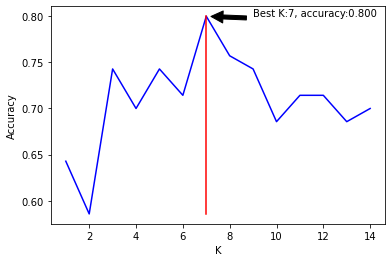

In [154]:
plt.plot(range(1,Ks), Test_accuracies[1:], 'b')
plt.annotate('Best K:{}, accuracy:{:.3f}'.format(best_k, best_accuracy),
             xy=(best_k, best_accuracy), xytext = ( best_k + 2, best_accuracy),
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
line = [(best_k, best_k), (min(Test_accuracies[1:]), best_accuracy),'r',]
plt.plot(*line)

plt.ylabel('Accuracy')
plt.xlabel('K')
plt.show();

In [155]:
best_k

7

In [156]:
kNeighbor = KNeighborsClassifier(n_neighbors = best_k).fit(X_train,y_train)
sum(y_test == kNeighbor.predict(X_test))/len(y_test)

0.8

In [157]:
kNeighbor

KNeighborsClassifier(n_neighbors=7)

## Decision Tree

In [158]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 

In [159]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree.fit(X_train,y_train)

yhat = loanTree.predict(X_train)
sum(y_train == yhat )/len(y_train)

0.7463768115942029

## Support Vector Machine

In [164]:
from sklearn import svm
svm_Model = svm.SVC(kernel='rbf')
svm_Model.fit(X_train, y_train) 

yhat = svm_Model.predict(X_test)
sum(y_test == yhat)/len(y_test)

0.7428571428571429

## Logistic Regression

In [165]:
#from sklearn.linear_model import LogistricRegression
from sklearn.linear_model import LogisticRegression

In [166]:
LR_Model = LogisticRegression( C = 0.01, solver = 'liblinear')
LR_Model.fit(X_train, y_train)

lrYhat = LR_Model.predict(X_test)
lrYhat_prob = LR_Model.predict_proba(X_test)
sum(lrYhat == y_test)/len(y_test)

0.6857142857142857

# Model Evaluation using Test set

In [168]:
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_score

In [169]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-04-20 22:12:13--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-04-20 22:12:14 (119 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation

In [170]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


# Test Data Pre-processing: Feature selection/extraction same as done with train data

In [171]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [172]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [173]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if x > 3 else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1], inplace = True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [174]:
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature, pd.get_dummies(test_df['education'])], axis = 1)
test_Feature.drop(['Master or Above'], axis = 1, inplace = True)
test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [175]:
X_test = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)
X_test[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [176]:
y_test = test_df['loan_status'].values
y_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [177]:
y_test

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION'], dtype=object)

In [178]:
kNByhat = kNeighbor.predict(X_test)
dTreeYhat = loanTree.predict(X_test)
svmYhat = svm_Model.predict(X_test)
lrYhat = LR_Model.predict(X_test)
lrYhat_prob = LR_Model.predict_proba(X_test)

In [181]:
data = []
idx = ['KNN', 'Decision Tree', 'SVM','LogisticRegression']

for yhat, Model_Name in zip([kNByhat, dTreeYhat, svmYhat, lrYhat],idx ):
    
#     jaccard = jaccard_score(y_test, yhat, average = None )[-1]
    jaccard = jaccard_score ( y_test, yhat, pos_label="PAIDOFF")
    
    F1 = f1_score(y_test, yhat, average='weighted')
    
    data.append({'Jaccard': jaccard,
                 'F1-score':F1,
                })
    print('{}'.format('-'*42))
    print('{:<21} Jaccard index: {:.2f}'.format(Model_Name, jaccard))
    print('{:<21}      F1-score: {:.2f}'.format('',F1))
    
data[-1]['LogLoss'] = log_loss(y_test, lrYhat_prob)
print('{:<21}       LogLoss: {:.2f}'.format('',data[-1]['LogLoss']))

------------------------------------------
KNN                   Jaccard index: 0.67
                           F1-score: 0.66
------------------------------------------
Decision Tree         Jaccard index: 0.66
                           F1-score: 0.74
------------------------------------------
SVM                   Jaccard index: 0.78
                           F1-score: 0.76
------------------------------------------
LogisticRegression    Jaccard index: 0.74
                           F1-score: 0.66
                            LogLoss: 0.57


## Report

In [182]:
accuracy_report = pd.DataFrame(data, 
                         index = ['KNN', 'Decision Tree', 'SVM','LogisticRegression'],
                         columns = ['Jaccard','F1-score','LogLoss'],
                        )

In [183]:
pd.set_option('precision', 2)
accuracy_report

,Jaccard,F1-score,LogLoss
KNN,0.67,0.66,NaN
Decision Tree,0.66,0.74,NaN
SVM,0.78,0.76,NaN
LogisticRegression,0.74,0.66,0.57
